Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 200       |
|    ep_rew_mean      | -1.24e+05 |
|    exploration_rate | 0.848     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 4927      |
|    time_elapsed     | 0         |
|    total_timesteps  | 800       |
-----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 200       |
|    ep_rew_mean      | -1.14e+05 |
|    exploration_rate | 0.696     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 1359      |
|    time_elapsed     | 1         |
|    total_timesteps  | 1600      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 18        |
|    n_updates        | 149       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 200       |
|    ep_rew_mean      | -8.46e+04 |
|    exploration_rate | 0.544     |
| time/               |           |
|    episodes         | 12        |
|    fps              | 1210      |
|    time_elapsed     | 1         |
|    total_timesteps  | 2400      |
| train/              |           |
|    learning_rate    | 0.001     |
|    loss             | 18.2

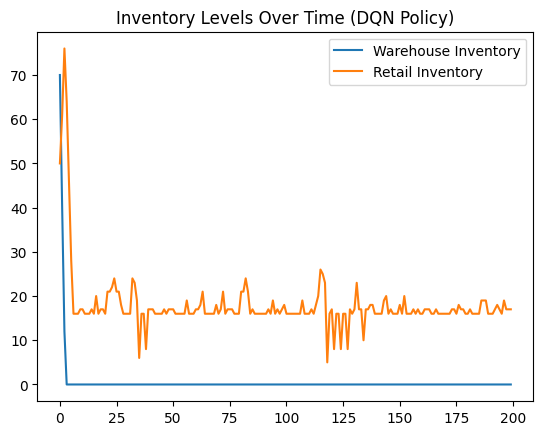

In [4]:
# -----------------------------
# 1. Imports
# -----------------------------
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env

# -----------------------------
# 2. Custom Supply Chain Environment
# -----------------------------
class SupplyChainEnv(gym.Env):
    """
    Single-warehouse, single-retailer supply chain environment
    State  : [warehouse_inventory, retailer_inventory, pipeline_orders, last_demand]
    Action : order quantity from supplier
    """

    def __init__(self):
        super(SupplyChainEnv, self).__init__()

        # Inventory limits
        self.max_inventory = 200
        self.max_order = 50
        self.lead_time = 2

        # Costs
        self.holding_cost = 1.0
        self.stockout_cost = 5.0
        self.order_cost = 2.0

        # Action space (order quantity)
        self.action_space = spaces.Discrete(self.max_order + 1)

        # Observation space
        self.observation_space = spaces.Box(
            low=0,
            high=self.max_inventory,
            shape=(4,),
            dtype=np.float32
        )

        # Call reset to initialize state
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.warehouse_inventory = 100
        self.retail_inventory = 50
        self.pipeline_orders = [0] * self.lead_time
        self.last_demand = 20
        self.current_step = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return np.array([
            self.warehouse_inventory,
            self.retail_inventory,
            sum(self.pipeline_orders),
            self.last_demand
        ], dtype=np.float32)

    def step(self, action):
        # Place order
        order_qty = action
        self.pipeline_orders.append(order_qty)
        arrived = self.pipeline_orders.pop(0)

        # Receive inventory
        self.warehouse_inventory = min(
            self.warehouse_inventory + arrived,
            self.max_inventory
        )

        # Demand realization
        demand = np.random.poisson(20)
        self.last_demand = demand

        # Fulfill demand
        sales = min(self.retail_inventory, demand)
        stockout = max(0, demand - self.retail_inventory)
        self.retail_inventory -= sales

        # Transfer from warehouse to retail
        transfer = min(self.warehouse_inventory, 30)
        self.warehouse_inventory -= transfer
        self.retail_inventory += transfer

        # Costs
        holding_cost = self.holding_cost * (
            self.warehouse_inventory + self.retail_inventory
        )
        stockout_cost = self.stockout_cost * stockout
        ordering_cost = self.order_cost * order_qty

        total_cost = holding_cost + stockout_cost + ordering_cost
        reward = -total_cost

        self.current_step += 1
        done = self.current_step >= 200

        return self._get_obs(), reward, done, False, {}

# -----------------------------
# 3. Environment Check
# -----------------------------
env = SupplyChainEnv()
check_env(env, warn=True)

# -----------------------------
# 4. Train DQN Agent
# -----------------------------
dqn_model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=0.001,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=64,
    gamma=0.99,
    verbose=1
)

dqn_model.learn(total_timesteps=50000)

# -----------------------------
# 5. Evaluate Agent
# -----------------------------
def evaluate(model, env, episodes=10):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards)

avg_reward = evaluate(dqn_model, env)
print("Average Evaluation Reward:", avg_reward)

# -----------------------------
# 6. PPO (Optional Advanced Model)
# -----------------------------
ppo_model = PPO(
    policy="MlpPolicy",
    env=env,
    learning_rate=0.0003,
    gamma=0.99,
    verbose=1
)

ppo_model.learn(total_timesteps=50000)

# -----------------------------
# 7. Visualization
# -----------------------------
obs, _ = env.reset()
warehouse, retail = [], []

for _ in range(200):
    action, _ = dqn_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)
    warehouse.append(obs[0])
    retail.append(obs[1])
    if done or truncated:
        break

plt.figure()
plt.plot(warehouse, label="Warehouse Inventory")
plt.plot(retail, label="Retail Inventory")
plt.legend()
plt.title("Inventory Levels Over Time (DQN Policy)")
plt.show()


